# Setup

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import fastparquet

In [4]:
DATA_DIR = Path("../data")
RAW_TRAIN_PATH = DATA_DIR / "train.parquet"
RAW_TEST_PATH = DATA_DIR / "test.parquet"
CLEAN_TRAIN_PATH = DATA_DIR / "train_clean_v3.parquet"
CLEAN_TEST_PATH = DATA_DIR / "test_clean_v3.parquet"

### Reduce memory usage (no more float64 default)

In [5]:
def reduce_mem_usage(dataframe, dataset):    
    print(f'Reducing memory usage for: {dataset}')
    initial_mem = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type).startswith('int'):
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            else:
                dataframe[col] = dataframe[col].astype(np.int64)
        elif str(col_type).startswith('float'):
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem = dataframe.memory_usage().sum() / 1024**2
    print(f'--- Memory usage before: {initial_mem:.2f} MB')
    print(f'--- Memory usage after: {final_mem:.2f} MB')
    print(f'--- Decreased by {(100 * (initial_mem - final_mem) / initial_mem):.1f}%\n')
    return dataframe

### Load data

In [ ]:
train = pd.read_parquet(RAW_TRAIN_PATH, engine="fastparquet")
test = pd.read_parquet(RAW_TEST_PATH, engine="fastparquet")

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

Reducing memory usage for: train
--- Memory usage before: 3598.94 MB
--- Memory usage after: 965.94 MB
--- Decreased by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased by 73.2%



In [10]:
train.to_parquet(CLEAN_TRAIN_PATH, engine="fastparquet", index=False)
test.to_parquet(CLEAN_TEST_PATH, engine="fastparquet", index=False)
print(f"Saved cleaned train to: {CLEAN_TRAIN_PATH}")
print(f"Saved cleaned test to: {CLEAN_TEST_PATH}")

Saved cleaned train to: ../data/train_clean_v3.parquet
Saved cleaned test to: ../data/test_clean_v3.parquet


In [11]:
print("NaNs in training set:")
print(train.isna().sum().sort_values(ascending=False).head())

print("\nInfs in training set:")
print(np.isinf(train.select_dtypes(include=[np.number])).sum().sort_values(ascending=False).head())

NaNs in training set:
bid_qty     0
ask_qty     0
buy_qty     0
sell_qty    0
volume      0
dtype: int64

Infs in training set:
X702    525887
X703    525887
X704    525887
X705    525887
X706    525887
dtype: int64


### Correlation heatmap

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

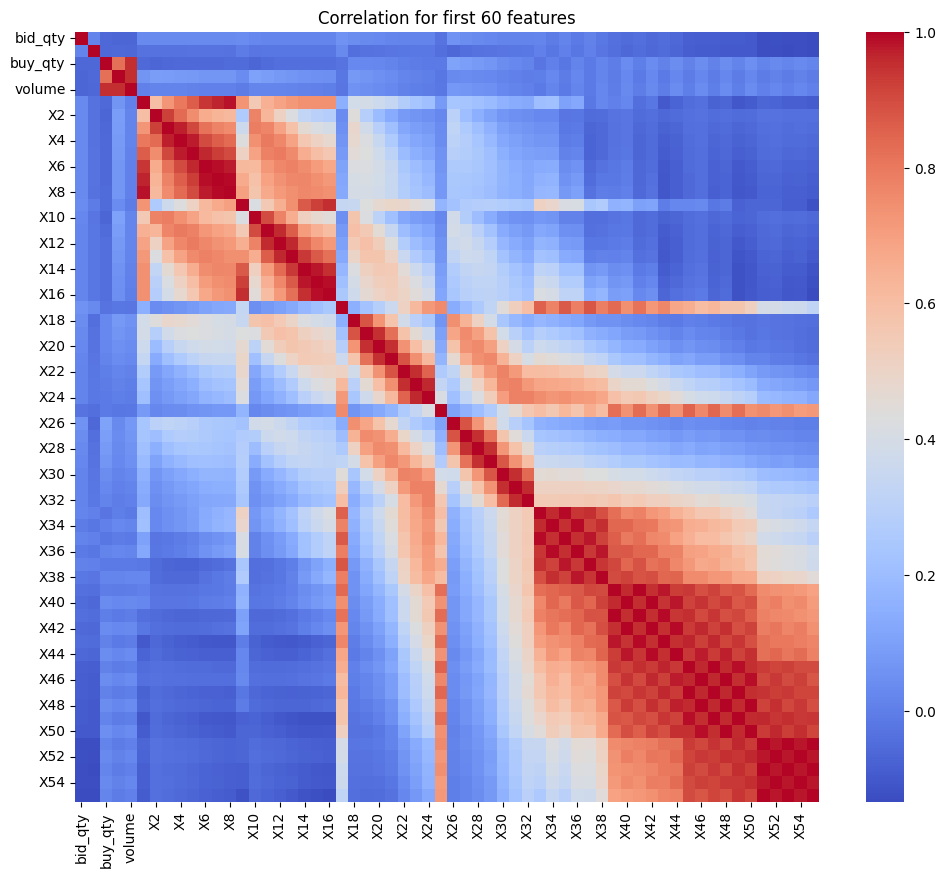

In [13]:
# Correlation heatmap
X_cols = [c for c in train.columns]
plt.figure(figsize=(12, 10))
sns.heatmap(train[X_cols[:60]].corr(), cmap='coolwarm')
plt.title("Correlation for first 60 features")
plt.show()